In [10]:
import pandas as pd
import numpy as np
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from data_reduction.ranking import getPHOutlierScores_restrictedDim as phl_selection
from data_reduction.representativeness import find_epsilon

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from my_dataset_reduction.phl import getPHOutlierScores_restrictedDim as my_phl_selection

dbpath = '../datasets/dry+bean+dataset/DryBeanDataset/Dry_Bean_Dataset.xlsx'
target = 'Class'

SEED = 2025
np.random.seed(SEED)

PROFILING = False # False para tomar todo el dataset
results_folder = '../results/compare'

# Check if the results folder exists, if not create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [11]:
df = pd.read_excel(dbpath, )

pd.set_option('display.max_columns', None)
print("Tamaño del dataset: ", df.shape)
df.describe()

Tamaño del dataset:  (13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


In [12]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


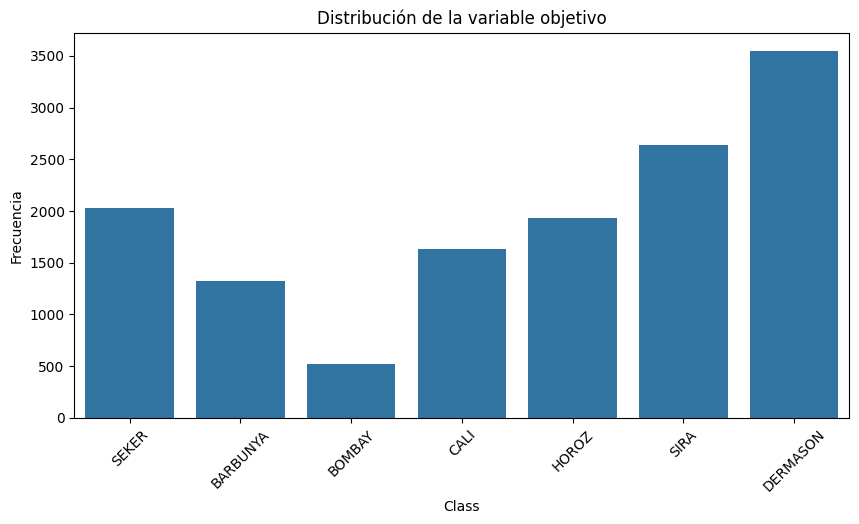

In [13]:
# Show bar plot of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x=target, data=df)
plt.title('Distribución de la variable objetivo')
plt.xlabel(target)
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [14]:
if PROFILING:
    df = df.sample(1000, random_state=SEED)

In [15]:
# Train test split
X = df.drop(columns=[target])
X = np.array(X)

# Convertir la columna target a entero
if not pd.api.types.is_integer_dtype(df[target]):
    le = LabelEncoder()
    y = le.fit_transform(df[target])
else:
    y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
reduction_methods = ['PHL', 'MY_PHL']
reps = 1 #2
deltas = [0.05, 0.1, 0.25]
metrics = ['time']

df_compare_phl = pd.DataFrame(columns=['delta'] + ['time_' + m for m in reduction_methods])

if os.path.exists(results_folder + '/compare_phl.csv'):
    df_compare_phl = pd.read_csv(results_folder + '/compare_phl.csv')
else:
    for delta in deltas:
        for n in range(reps):
            print(f"Reducing dataset delta: {delta}, iteration: {n}")
            # Reduce the dataset using PHL method
            t0 = time.time()
            outlier_scores_point_cloud_original_order,set_of_super_outliers, super_outlier_indices = phl_selection(X_train_scaled, delta, 2)
            reduction_time = time.time() - t0
            print(f"PHL: {reduction_time:.2f} seconds")

            # Reduce the dataset using my PHL method
            t0 = time.time()
            my_outlier_scores_point_cloud_original_order,my_set_of_super_outliers, my_super_outlier_indices = my_phl_selection(X_train_scaled, delta, 2)
            reduction_time_my = time.time() - t0

            print(f"MY_PHL: {reduction_time_my:.2f} s")

            # Store the results
            df_compare_phl = df_compare_phl.append({
                        'delta': delta,
                        'time_PHL' : reduction_time,
                        'time_MY_PHL' : reduction_time_my,
                        'equal' : np.array_equal(outlier_scores_point_cloud_original_order, my_outlier_scores_point_cloud_original_order),
                    }, ignore_index=True)
    # Save the results
    df_compare_phl.to_csv(f'{results_folder}/phl_results.csv', index=False)

Reducing dataset delta: 0.05, iteration: 0
PHL: 43.86 seconds
MY_PHL: 2.67 s
Reducing dataset delta: 0.1, iteration: 0


/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


PHL: 42.79 seconds
MY_PHL: 2.60 s
Reducing dataset delta: 0.25, iteration: 0


/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/home/santiago/miniconda3/envs/data_reduction/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  

PHL: 43.92 seconds
MY_PHL: 2.69 s


In [18]:
df_compare_phl

,delta,time_PHL,time_MY_PHL,equal
0,0.05,43.858493,2.673440,1.0
1,0.10,42.785874,2.601871,1.0
2,0.25,43.921870,2.691595,1.0
